In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


Text(0, 0.5, 'Amplitude relative to face-on')

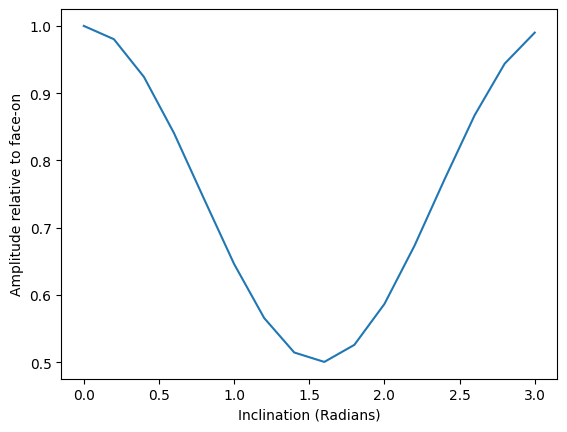

In [2]:
# Generate a gravitational waveform
peaks = []
inclinations = np.arange(0, np.pi, .2)
for inc in inclinations:
    hp, _ = get_td_waveform(approximant="SEOBNRv2",
                         mass1=20, mass2=20,
                         delta_t=1.0/1024, f_lower=50.0,
                         distance=100, 
                         inclination=inc)
    peaks.append(hp.max())
    
peaks = np.array(peaks)
peaks /= peaks.max()
plt.plot(inclinations, peaks)
plt.xlabel('Inclination (Radians)')
plt.ylabel('Amplitude relative to face-on')

In [34]:
def modulate_coherent_coherent_td_wf(hp,hc,damp,dphi, sel):
    hp_fd = hp.to_frequencyseries()
    hc_fd = hc.to_frequencyseries()
    hp_fd,hc_fd = modulate_coherent_coherent_fd_wf(hp_fd,hc_fd,damp,dphi, sel)
    return hp_fd.to_timeseries(),hc_fd.to_timeseries()

def modulate_coherent_coherent_fd_wf(hp,hc,damp,dphi, sel):
    modif = np.where(sel, (1.0 + damp) * (2.0 + 1j*dphi) / (2.0 - 1j*dphi), 1.0)
    new_hp = modif*hp.copy()
    new_hc = modif*hc.copy()
    return new_hp,new_hc

def construct_modulation(fs, knots, damp_hts, dphi_hts, sel):
    # Construct a spline interpolation of the modulation parameters
    damp_spline = interp1d(knots, damp_hts, kind='cubic')
    dphi_spline = interp1d(knots, dphi_hts, kind='cubic')
    
    # Construct the modulation
    damp = np.zeros_like(fs) 
    damp[sel] = damp_spline(fs[sel])
    dphi = np.zeros_like(fs)
    dphi[sel] = dphi_spline(fs[sel])
    return damp, dphi


f_low = 40.0
srate = 1024.0
delta_t = 1.0/srate
duration = 0.25
df = 1.0/duration



Text(0, 0.5, 'Strain')

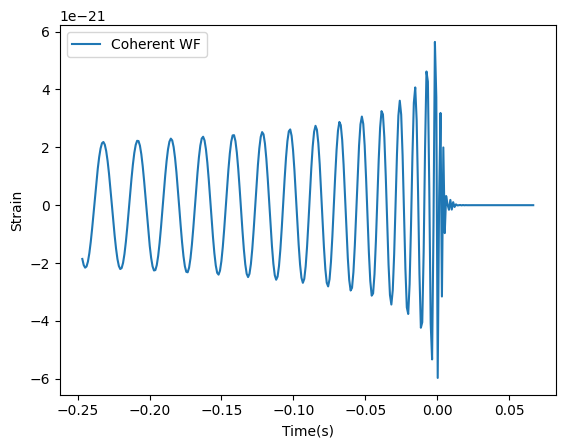

In [35]:
from pycbc.detector import Detector

# Generate the gravitation-wave polarizations
hp, hc = get_td_waveform(approximant="SEOBNRv2",
                         mass1=20, mass2=20,
                         delta_t=1.0/1024, f_lower=40.0,
                         distance=100, 
                         inclination=0)



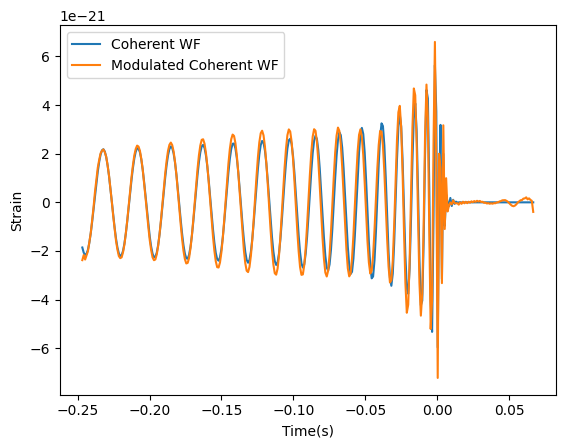

In [37]:
# Generate the gravitation-wave polarizations
N = 10
fs = hp.to_frequencyseries().sample_frequencies

knots = np.exp(np.linspace(np.log(f_low), np.log(srate/2.), N))
sel = (fs > f_low) & (fs < srate/2.)
damp_hts = np.random.uniform(0.0, 0.15, N)
dphi_hts = np.random.uniform(0.0, np.pi/6., N)
damp, dphi = construct_modulation(fs, knots, damp_hts, dphi_hts, sel)
hpmod, hcmod = modulate_coherent_coherent_td_wf(hp,hc,damp,dphi, sel)

plt.plot(hp.sample_times, hp+hc, label='Coherent WF')
plt.plot(hpmod.sample_times, hpmod+hcmod, label='Modulated Coherent WF')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Strain');

Text(0, 0.5, 'Strain')

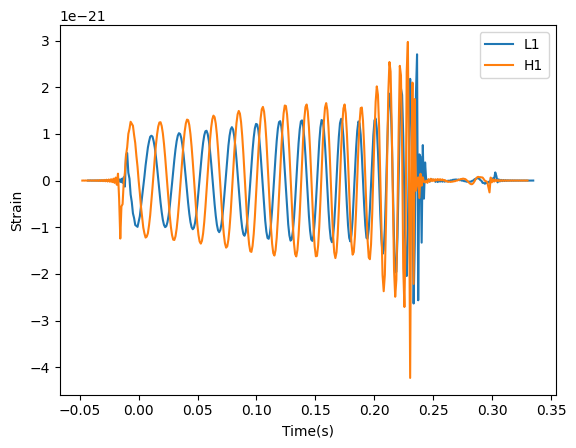

In [38]:

# Map to how a detector would see the signal for a specific sky location
# and time
right_ascension = 1.7 # Radians
declination = 1.7 
polarization = 0
hpmod.start_time = hcmod.start_time = 0 # GPS seconds

# Calculate the straing that each of the LIGO detectors would observe
for name in ['L1', 'H1']:
    det = Detector(name)
    det_strain = det.project_wave(hpmod, hcmod, 
                                 right_ascension, declination,
                                 polarization)
    plt.plot(det_strain.sample_times, det_strain, label=name)
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('Strain')

# Notice that the strain in each detector is not the same. The time
# delay between detectors allow us to triangulate a source. The relative 
# amplitude and phase also contribute information about the sky location.

# Try other sky locations and see what happens!

Text(0.5, 0, 'GPS Time (s)')

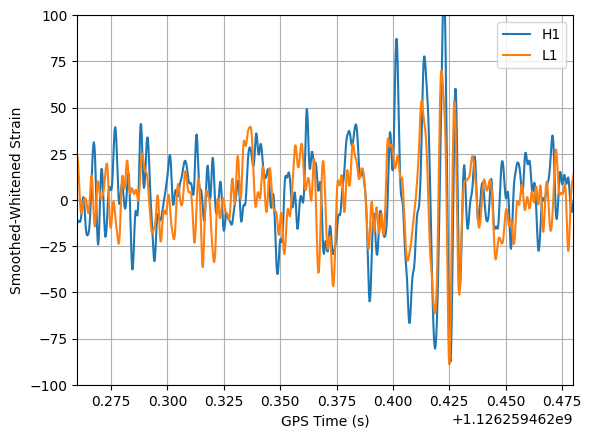

In [5]:
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger

for ifo in ['H1', 'L1']:
    # Read data: The data is available to the public through losc.ligo.org!
    ts = Merger("GW150914").strain(ifo)
    
    # Estimate the noise spectrum and use it to whiten the data
    psd = interpolate(welch(ts), 1.0 / ts.duration)
    white_strain = (ts.to_frequencyseries() / psd ** 0.5).to_timeseries()

    # remove frequencies below and above where the main portion of the signal lies
    smooth = highpass_fir(white_strain, 35, 8)
    smooth = lowpass_fir(smooth, 300, 8)

    # time shift and flip L1 to match the time of arrival and phase of Hanford
    if ifo == 'L1':
        smooth *= -1
        smooth.roll(int(.007 / smooth.delta_t))

    plt.plot(smooth.sample_times.numpy(), smooth.numpy(), label=ifo)

# Plot the region around the signal (time is in gps seconds)
plt.legend()
plt.xlim(1126259462.26, 1126259462.48)
plt.ylabel('Smoothed-Whitened Strain')
plt.grid()
plt.ylim(-100, 100)
plt.xlabel('GPS Time (s)')

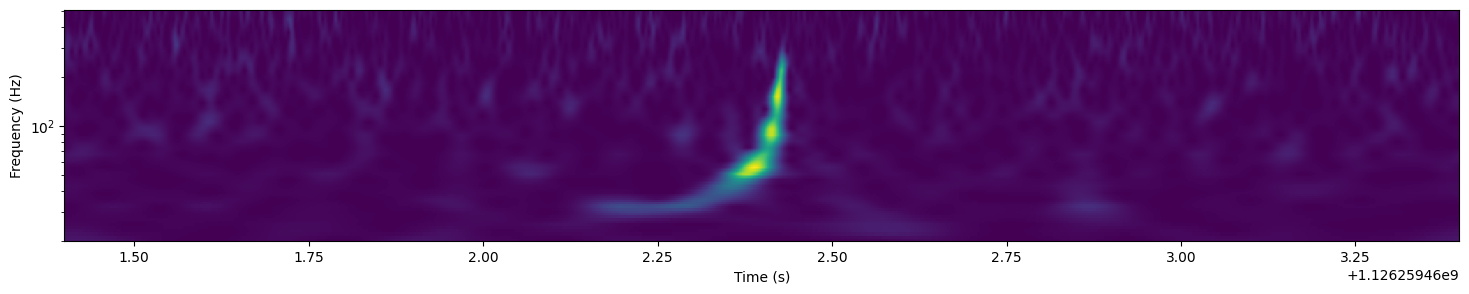

In [6]:
ts = Merger("GW150914").strain("H1")

ts = ts.whiten(4, 4)
zoom = ts.time_slice(1126259462.4 - 1, 1126259462.4 + 1)
times, freqs, power = zoom.qtransform(.001, 1, frange=(20, 512), qrange=(4, 64))

plt.figure(figsize=(18, 3))
plt.pcolormesh(times, freqs, power)
plt.ylim(20, 512)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim(times.min(), times.max())
plt.yscale('log')